## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape

(32, 32, 3)

[9]


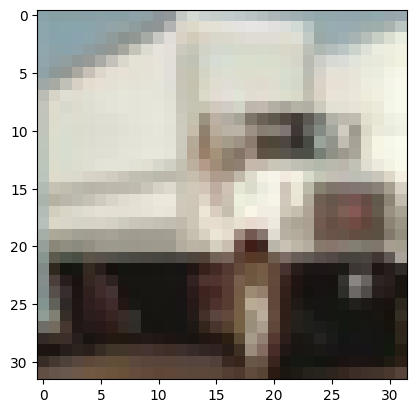

In [4]:
## Let's look at one of the images

print(y_train[444])
plt.imshow(x_train[444]);

In [4]:
num_classes = 10
#Dobbiamo trasformarle in onehot encoding
print(y_test)
y_test_lab=np.copy(y_test)
print(y_test_lab)
#Metodo categorical: traduce il dataset in onehot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

[[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]
[[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]


In [6]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444] #solo ultimo valore =1 (camion)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

(10000, 32, 32, 3)


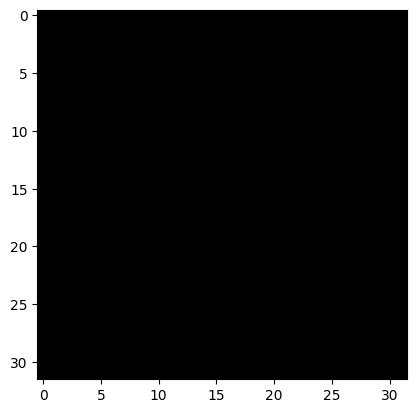

In [7]:
# As before, let's make everything float and scale
#NORMALIZZAZIONE dei valori (su 255 dato che siamo in rgb) in un range 0,1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 # Normalization is enough here
x_test /= 255

#print(x_train[444]) #ora ha valori tra 0 e 1
print(x_test.shape)
plt.imshow(x_train[444]); # ora non si vede più (valori tutti vicini allo zero)

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Tensorflow

### Conv2D

```python
keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
(reshape to vector -> un unico array)
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [8]:
# Let's build a CNN using Keras' Sequential capabilities

model_1 = Sequential()

#Con il padding ci assicuriamo di usare tutta l'immagine (ad esempio: lo stride se esce dall'immagine non viene effettuato -> perdo il bordo)
#anche con stride a 1 perdo i pixel che il kernel non riesce a coprire

## 5x5 convolution with 2x2 stride and 32 filters
#padding same -> tanto padding tanto quanto necessario per avere la stessa dim in output sulla base del kernel
#problema: non considera lo stride nel same -> avrò comunque un'img minore (ma lavoro su tutti i pixel del bordo)
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same', # output size would be the same of input size if stride were (1,1)
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2))) #diminuisco ancora l'immagine
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1 = UN UNICO VETTORE
model_1.add(Flatten())
#LAYER FULLY CONNECTED
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        2432      
                                                                 
 activation (Activation)     (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 activation_1 (Activation)   (None, 6, 6, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                        

**Question:** why the second Conv layer's output is 6x6? Stride of 2 should define the ratio between the input and output size, thus one could expect to have 8x8. What's happen here?

We still have 181K parameters, even though this is a "small" model.


In [9]:
batch_size = 32

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

run_hist_1=model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=15,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/15
1563/1563 [==============================] - 41s 25ms/step - loss: 1.7562 - accuracy: 0.3593 - val_loss: 1.6401 - val_accuracy: 0.4223
Epoch 2/15
1563/1563 [==============================] - 38s 24ms/step - loss: 1.4722 - accuracy: 0.4693 - val_loss: 1.2882 - val_accuracy: 0.5431
Epoch 3/15
1563/1563 [==============================] - 40s 26ms/step - loss: 1.3602 - accuracy: 0.5130 - val_loss: 1.2653 - val_accuracy: 0.5537
Epoch 4/15
1563/1563 [==============================] - 39s 25ms/step - loss: 1.2921 - accuracy: 0.5397 - val_loss: 1.3096 - val_accuracy: 0.5475
Epoch 5/15
1563/1563 [==============================] - 39s 25ms/step - loss: 1.2473 - accuracy: 0.5586 - val_loss: 1.1524 - val_accuracy: 0.5977
Epoch 6/15
1563/1563 [==============================] - 38s 24ms/step - loss: 1.2141 - accuracy: 0.5715 - val_loss: 1.1552 - val_accuracy: 0.5938
Epoch 7/15
1563/1563 [==============================] - 36s 23ms/step - loss: 1.1944 - accuracy: 0.5783 - val_loss: 1.1253 -

In [11]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
y_pred_class = np.argmax(model_1.predict(x_test), axis=-1)
#y_pred_prob = model_1.predict_proba(x_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test_lab,y_pred_class)))

313/313 [==============================] - 2s 6ms/step
accuracy is 0.651
<function confusion_matrix at 0x000002D59C7D80D0>


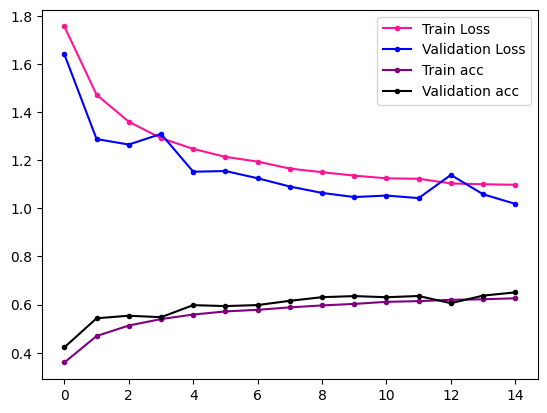

In [16]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'deeppink', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.plot(run_hist_1.history["accuracy"],'purple', marker='.', label="Train acc")
ax.plot(run_hist_1.history["val_accuracy"],'k', marker='.', label="Validation acc")
ax.legend()
#si alza la validation loss = tendenza ad overfitting


### Exercise
Our previous model had the structure:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. Build a more complicated model with the following pattern:
- Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification. Pay attention when choosing strides and filters size.

- Use strides of 1 for all convolutional layers.

2. How many parameters does your model have?  How does that compare to the previous model?

3. Train it for 5 epochs.  What do you notice about the training time, loss and accuracy numbers (on both the training and validation sets)?

5. Try different structures and run times, and see how accurate your model can be.


In [17]:
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', # output size would be the same of input size if stride were (1,1)
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (1,1)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (1,1),  # output size would be the same of input size if stride were (1,1)
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (1,1)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 activation_4 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 activation_5 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 32)        25632     
                                                      

In [18]:
batch_size = 1000

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

run_hist_1=model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/5
50/50 [==============================] - 164s 3s/step - loss: 2.1900 - accuracy: 0.1889 - val_loss: 2.1239 - val_accuracy: 0.2265
Epoch 2/5
50/50 [==============================] - 164s 3s/step - loss: 1.9649 - accuracy: 0.2938 - val_loss: 1.7733 - val_accuracy: 0.3618
Epoch 3/5
50/50 [==============================] - 142s 3s/step - loss: 1.8430 - accuracy: 0.3391 - val_loss: 1.7053 - val_accuracy: 0.3936
Epoch 4/5
50/50 [==============================] - 155s 3s/step - loss: 1.7336 - accuracy: 0.3793 - val_loss: 1.6875 - val_accuracy: 0.3761
Epoch 5/5
50/50 [==============================] - 135s 3s/step - loss: 1.6594 - accuracy: 0.4043 - val_loss: 1.5711 - val_accuracy: 0.4230


In [4]:
#Grafico 2
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'deeppink', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"], 'black', marker= '.', label="Validation Loss")
ax.plot(run_hist_1.history["accuracy"],'orange', marker = "*", label = "Train Accuracy")
ax.plot(run_hist_1.history['val_accuracy'],'darkslateblue', marker = "*", label = "Validation accuracy")
ax.legend()

NameError: name 'plt' is not defined

In [3]:
#prova di predizione
result = model_1.predict(x_train)

NameError: name 'model_1' is not defined

In [2]:
#Vediamo se ha predetto correttamente
classi = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def associa (classi, vector):
    #Associo i valori
    dizionario = {}
    index = 0
    for key in classi:
        dizionario[key] = vector[index]
        index = index + 1
    print("probabilità assegnate:")
    #print(dizionario) # corretto ->camion

    sorted_tuples = sorted(dizionario.items(), key=lambda item: item[1], reverse=True)
    dizionario = {k: v for k, v in sorted_tuples}
    #print(dizionario)
    for key, value in dizionario.items():
        print(key + " : " + '{:.2f}'.format(value * 100))
    print('-'*20)
    
    
plt.imshow(x_train[444]); #= truck
plt.imshow(x_train[0]); #= frog
associa(classi, result[444])
associa(classi, result[0]) 




NameError: name 'x_train' is not defined